In [67]:
from pybedtools import BedTool
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import utils
from upsetplot import UpSet, from_contents
from matplotlib_venn import venn2

In [68]:
def intersect_bed_files(bed_file1, bed_file2):
    bed1 = BedTool(bed_file1)
    bed2 = BedTool(bed_file2)

    # Intersect and split regions
    # Retain annotations from bed_file2 for overlapping regions
    merged = bed1.intersect(bed2, wa=True, wb=True)#.saveas("output/temp_intersect.bed")

    # Split non-overlapping regions from bed_file1
    non_overlapping = bed1.subtract(bed2)#.saveas("output/temp_non_overlapping.bed")

    return merged, non_overlapping

In [69]:
def intersect_bed_objects(bed_file1, bed_file2):
    bed1 = bed_file1
    bed2 = bed_file2

    # Intersect and split regions
    # Retain annotations from bed_file2 for overlapping regions
    merged = bed1.intersect(bed2, wa=True, wb=True)#.saveas("output/temp_intersect.bed")

    # Split non-overlapping regions from bed_file1
    non_overlapping = bed1.subtract(bed2)#.saveas("output/temp_non_overlapping.bed")

    return merged, non_overlapping

In [70]:
bed_allpeaks = "/data2st1/junyi/output/atac0416/cCRE/peak.bed"


bed_encode = "/data2st1/junyi/output/atac0416/cCRE/mm10-cCREs.bed"

#https://www.encodeproject.org/annotations/ENCSR127YRL/
bed_rdhs = "/data2st1/junyi/output/atac0416/cCRE/ENCFF414KHO.bed"



In [71]:
merged, non_overlapping = intersect_bed_files(bed_allpeaks, bed_encode)

In [72]:
inter_rdhs, non_overlapping_rdhs = intersect_bed_files(bed_allpeaks, bed_rdhs)

In [73]:
inter_rdhs.saveas("/data2st1/junyi/output/atac0416/cCRE/overlap_rdhs.bed")
non_overlapping.saveas("/data2st1/junyi/output/atac0416/cCRE/non_overlapp_rdhs.bed")

<BedTool(/data2st1/junyi/output/atac0416/cCRE/non_overlapp_rdhs.bed)>

In [74]:
len(merged), len(non_overlapping)

(295713, 1534765)

In [75]:
len(inter_rdhs), len(non_overlapping_rdhs)

(840623, 1836114)

In [76]:
bedall_peaks = BedTool(bed_allpeaks)

In [77]:
df_allpeaks = pd.read_csv(bed_allpeaks, sep="\t", header=None) 
df_allrdhs = pd.read_csv(bed_rdhs, sep="\t", header=None)

In [97]:
n_overlap = len(inter_rdhs)
n_cCRE = len(df_allpeaks)
n_rDHS = len(df_allrdhs)

In [98]:
venn2(subsets=( n_cCRE-n_overlap, n_rDHS-n_overlap, n_overlap), set_labels=('Our cCRE', 'ENCODE rDHS'))
plt.title("Venn Diagram of rDHS and Set B")
plt.savefig("/data2st1/junyi/output/atac0416/cCRE/venn_rdhs.svg", dpi=300, bbox_inches='tight')
plt.close()

In [80]:
df_allpeaks.columns = ["chr", "start", "end"]

In [81]:
df_allpeaks['names'] = df_allpeaks['chr'] + ":" + df_allpeaks['start'].astype(str) + "-" + df_allpeaks['end'].astype(str)

In [ ]:
annotations = [
    "/data2st1/junyi/generegion_vM23/intron_selected.bed",
    "/data2st1/junyi/generegion_vM23/exon_selected.bed",
    "/data2st1/junyi/generegion_vM23/promoter2k.bed",
    #"/data2st1/junyi/generegion_vM23/repeat.bed",
    "/data2st1/junyi/output/atac0416/cCRE/LINE.bed",
    "/data2st1/junyi/output/atac0416/cCRE/SINE.bed",
    "/data2st1/junyi/output/atac0416/cCRE/LTR.bed",
    "/data2st1/junyi/output/atac0416/cCRE/cpg.bed",
    "/data2st1/junyi/output/atac0416/cCRE/Other_repeats.bed",    
    "/data2st1/junyi/generegion_vM23/UTR.bed",
    "/data2st1/junyi/generegion_vM23/CDS.bed"
    "/data2st1/junyi/generegion_vM23/genebody.bed",
    "/data2st1/junyi/generegion_vM23/intergenic.bed"
]
dict_annot = {}
for file in annotations:
    name = file.split('/')[-1].replace('.bed', '')
    try:
        df_annot = utils.annotate_region(df_allpeaks,region_col='names', bedfile=file)
        dict_annot[name] = df_annot[df_annot.distance==0]
        dict_annot['cCRE'] = name
        print(f"Processed {file},{len(dict_annot[name])}")
    except:
        print(f"Error processing {file}")
        continue

In [134]:

gene_regions = {
    'intron': set(dict_annot['intron_selected'].names+"_"+dict_annot['intron_selected'].gene_name),
    'exon': set(dict_annot['exon_selected'].names+"_"+dict_annot['exon_selected'].gene_name),
    'promoter': set(dict_annot['promoter2k'].names+"_"+dict_annot['promoter2k'].gene_name),
    'UTR': set(dict_annot['UTR'].names+"_"+dict_annot['UTR'].gene_name),
    # 'LINE': set(dict_annot['LINE'].names+"_"+dict_annot['LINE'].gene_name),
    # 'SINE': set(dict_annot['SINE'].names+"_"+dict_annot['SINE'].gene_name),
    # 'LTR': set(dict_annot['LTR'].names+"_"+dict_annot['LTR'].gene_name),
    # 'repeat': set(dict_annot['Other_repeats'].names+"_"+dict_annot['Other_repeats'].gene_name),
    # 'cpg': set(dict_annot['cpg'].names+"_"+dict_annot['cpg'].gene_name)

    # 'intron': set(dict_annot['intron_selected'].names),
    # 'exon': set(dict_annot['exon_selected'].names),
    # 'promoter': set(dict_annot['promoter2k'].names),
    # 'UTR': set(dict_annot['UTR'].names),
    # 'repeat': set(dict_annot['repeat'].names),
    # 'cpg': set(dict_annot['cpg'].names),
    }
gene_regions = from_contents(gene_regions)

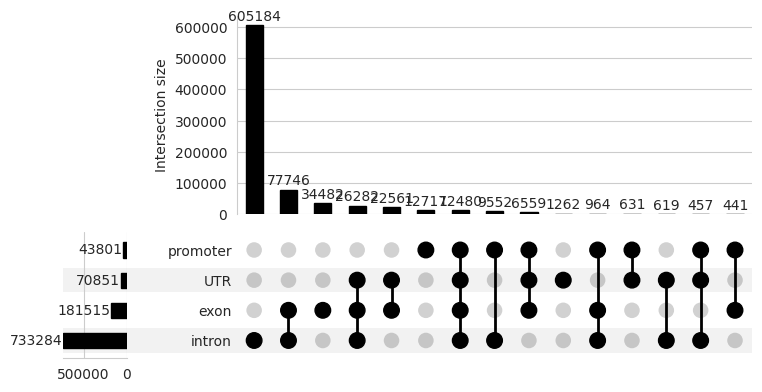

In [135]:

ax_dict = UpSet(gene_regions, subset_size="count", sort_by="cardinality", show_counts=True).plot()


In [141]:
df_annot[df_annot.distance==0]

,chr,start,end,names,gene_name,gene_id,gstart,gend,strand,annotation,distance
17,chr1,3074064,3074565,chr1:3074064-3074565,intergenic,intergenic,3074323.0,3102015.0,.,intergenic,0.0
18,chr1,3077696,3078197,chr1:3077696-3078197,intergenic,intergenic,3074323.0,3102015.0,.,intergenic,0.0
19,chr1,3083220,3083721,chr1:3083220-3083721,intergenic,intergenic,3074323.0,3102015.0,.,intergenic,0.0
20,chr1,3084590,3085091,chr1:3084590-3085091,intergenic,intergenic,3074323.0,3102015.0,.,intergenic,0.0
21,chr1,3087207,3087708,chr1:3087207-3087708,intergenic,intergenic,3074323.0,3102015.0,.,intergenic,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2683,chr1,9661093,9661594,chr1:9661093-9661594,intergenic,intergenic,9640583.0,9667414.0,.,intergenic,0.0
2684,chr1,9662107,9662608,chr1:9662107-9662608,intergenic,intergenic,9640583.0,9667414.0,.,intergenic,0.0
2685,chr1,9663138,9663639,chr1:9663138-9663639,intergenic,intergenic,9640583.0,9667414.0,.,intergenic,0.0
2686,chr1,9663926,9664427,chr1:9663926-9664427,intergenic,intergenic,9640583.0,9667414.0,.,intergenic,0.0


In [138]:
annotations = [
    "/data2st1/junyi/generegion_vM23/genebody.bed",
    "/data2st1/junyi/output/atac0416/cCRE/intergenic.bed"
    ]
dict_annot = {}
for file in annotations:
    name = file.split('/')[-1].replace('.bed', '')
    try:
        df_annot = utils.annotate_region(df_allpeaks,region_col='names', bedfile=file)
        dict_annot[name] = df_annot[df_annot.distance==0]
        dict_annot['cCRE'] = name
        print(f"Processed {file},{len(dict_annot[name])}")
    except:
        print(f"Error processing {file}")
        continue

Processed /data2st1/junyi/generegion_vM23/genebody.bed,814904


***** ERROR: illegal number ".". Exiting...


Processed /data2st1/junyi/output/atac0416/cCRE/intergenic.bed,1971


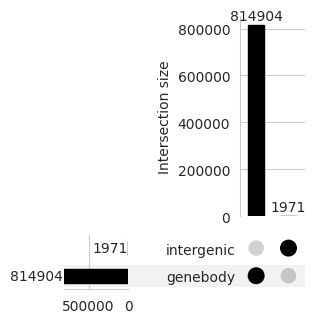

In [139]:
gene_regions = {
    'genebody': set(dict_annot['genebody'].names+"_"+dict_annot['genebody'].gene_name),
    'intergenic': set(dict_annot['intergenic'].names+"_"+dict_annot['intergenic'].gene_name),
    # 'promoter': set(dict_annot['promoter2k'].names+"_"+dict_annot['promoter2k'].gene_name),
    # 'UTR': set(dict_annot['UTR'].names+"_"+dict_annot['UTR'].gene_name),
    # 'LINE': set(dict_annot['LINE'].names+"_"+dict_annot['LINE'].gene_name),
    # 'SINE': set(dict_annot['SINE'].names+"_"+dict_annot['SINE'].gene_name),
    # 'LTR': set(dict_annot['LTR'].names+"_"+dict_annot['LTR'].gene_name),
    # 'repeat': set(dict_annot['Other_repeats'].names+"_"+dict_annot['Other_repeats'].gene_name),
    # 'cpg': set(dict_annot['cpg'].names+"_"+dict_annot['cpg'].gene_name)

    # 'intron': set(dict_annot['intron_selected'].names),
    # 'exon': set(dict_annot['exon_selected'].names),
    # 'promoter': set(dict_annot['promoter2k'].names),
    # 'UTR': set(dict_annot['UTR'].names),
    # 'repeat': set(dict_annot['repeat'].names),
    # 'cpg': set(dict_annot['cpg'].names),
    }
gene_regions = from_contents(gene_regions)
ax_dict = UpSet(gene_regions, subset_size="count", sort_by="cardinality", show_counts=True).plot()


In [ ]:
bed_intron = "/data2st1/junyi/generegion_vM33/intron.bed"

intron, non_intron = intersect_bed_files(bed_allpeaks, bed_intron)

df_intron = intron.to_dataframe().drop_duplicates(subset=['chrom', 'start', 'end'])

num_intron = len(df_intron)

In [ ]:
df_intron.to_csv("/data2st1/junyi/output/cCRE/ALL_sampled_peaks_intron.bed", sep="\t", index=False)

In [ ]:
bed_intron = "/data2st1/junyi/generegion_vM33/exon.bed"
exon = BedTool(bed_intron)
exon, non_ie = intersect_bed_objects(non_intron, exon)


In [ ]:
df_exon = exon.to_dataframe().drop_duplicates(subset=['chrom', 'start', 'end'])
num_exon = len(df_exon)

In [ ]:
promoter = BedTool("/data2st1/junyi/generegion_vM33/promoter.bed")
promoter, non_iep = intersect_bed_objects(non_ie, promoter)
df_promoter = promoter.to_dataframe().drop_duplicates(subset=['chrom', 'start', 'end'])
num_promoter = len(df_promoter)

In [ ]:
SINES = BedTool("/data2st1/junyi/generegion_vM33/sines.bed")
SINES, non_sines = intersect_bed_files(non_iep, SINES)
df_sines = SINES.to_dataframe().drop_duplicates(subset=['chrom', 'start', 'end'])
num_sines = len(df_sines)

In [ ]:
LTRS = BedTool("/data2st1/junyi/generegion_vM33/ltrs.bed")
LTRS, non_LTRS = intersect_bed_files(non_iep, LTRS)
df_ltrs = LTRS.to_dataframe().drop_duplicates(subset=['chrom', 'start', 'end'])
num_ltrs = len(df_ltrs)

In [ ]:
LINES = BedTool("/data2st1/junyi/generegion_vM33/lines.bed")
LINES, non_LINES = intersect_bed_files(non_iep, LINES)
df_lines = LINES.to_dataframe().drop_duplicates(subset=['chrom', 'start', 'end'])
num_lines = len(df_lines)


In [ ]:
intergenic = '/data2st1/junyi/generegion_vM33/intergenic.bed'
intergenic, non_intergenic = intersect_bed_files(bed_allpeaks, intergenic)
df_intergenic = intergenic.to_dataframe().drop_duplicates(subset=['chrom', 'start', 'end'])
num_intergenic = len(df_intergenic)

In [ ]:
other_repeat = '/data2st1/junyi/generegion_vM33/other_repeats.bed'
other_repeat, non_other_repeat = intersect_bed_files(non_iep, other_repeat)
df_other_repeat = other_repeat.to_dataframe().drop_duplicates(subset=['chrom', 'start', 'end'])
num_other_repeat = len(df_other_repeat)

In [ ]:
cpgi = '/data2st1/junyi/generegion_vM33/cpg.bed'
cpgi, non_cpgi = intersect_bed_files(bed_allpeaks, cpgi)
df_cpgi = cpgi.to_dataframe().drop_duplicates(subset=['chrom', 'start', 'end'])
num_cpgi = len(df_cpgi)

In [ ]:
num_cpgi

In [ ]:
import seaborn as sns

data = {'Region': ['Intron', 'Exon', 'Promoter', 'SINES', 'LTRs', 'LINES', 'Intergenic', 'Other Repeats', 'CpG Islands'],
        'Number of Peaks': [num_intron, num_exon, num_promoter, num_sines, num_ltrs, num_lines, num_intergenic, num_other_repeat, num_cpgi]}
df = pd.DataFrame(data)


In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(6,6))
plt.pie(df['Number of Peaks'], labels=df['Region'], autopct='%1.1f%%',pctdistance=1.15,labeldistance=1.28)
plt.show()


In [ ]:
import subprocess
filename= '/data2st1/junyi/output/cCRE/ALL_sampled_peaks.bed'
command_str = f"/home/junyichen/liftOver {filename} /data2st1/junyi/mm39ToMm10.over.chain.gz /data2st1/junyi/output/cCRE/ALL_sampled_peaks_mm10.bed /data2st1/junyi/output/cCRE/peaks_unmap.bed"
print(command_str)
subprocess.run(command_str, shell=True)

In [ ]:
bed_allpeaks = "/data2st1/junyi/output/cCRE/ALL_sampled_peaks_mm10.bed"
bed_encode = "/data2st1/junyi/output/convert_enhancer.bed"

merged, non_overlapping = intersect_bed_files(bed_allpeaks, bed_encode)

In [ ]:
# merged.saveas("/data2st1/junyi/output/cCRE/merged_mm10.bed")
# non_overlapping.saveas("/data2st1/junyi/output/cCRE/non_overlapping_mm10.bed")

PermissionError: [Errno 13] Permission denied: '/data2st1/junyi/output/cCRE/merged_mm10.bed'

In [89]:
import pyBigWig

# 打开 bigWig 文件
bw = pyBigWig.open("/data2st1/junyi/phascon/mm10.60way.phastCons.bw")

In [90]:
import numpy as np
scores_list = []
with open("/data2st1/junyi/output/atac0416/cCRE/overlap_rdhs.bed", "r") as bed_file:
    for line in bed_file:
        chrom, start, end, name,_,_,_ = line.strip().split('\t')
        start = int(start)
        end = int(end)
        summit = (start +
                  end) // 2
        

        # 获取 PhastCons 分数
        scores = bw.values(chrom, summit -250, summit + 250)
        scores = [score for score in scores if score is not None]

        # 计算平均分数
        # mean_score = np.mean(scores)
        # print(f"Region {name} ({chrom}:{start}-{end}): Mean PhastCons score = {mean_score}")
        scores_list.append(scores)


In [91]:
scores_array = np.array(scores_list)
scores_array = np.nan_to_num(scores_array)
mean_value = np.mean(scores_array, axis=0)


In [92]:
scores_list_non = []

with open("/data2st1/junyi/output/atac0416/cCRE/non_overlapp_rdhs.bed", "r") as bed_file:
    for line in bed_file:
        chrom, start, end= line.strip().split('\t')
        start = int(start)
        end = int(end)
        summit = (start +
                  end) // 2
        

        # 获取 PhastCons 分数
        try:
            scores = bw.values(chrom, summit -250, summit + 250)
            scores = [score for score in scores if score is not None]
        except:
            continue    
        # 计算平均分数
        # mean_score = np.mean(scores)
        # print(f"Region {name} ({chrom}:{start}-{end}): Mean PhastCons score = {mean_score}")
        scores_list_non.append(scores)


In [93]:
scores_array_non = np.array(scores_list_non)
scores_array_non = np.nan_to_num(scores_array_non)
mean_value_non = np.mean(scores_array_non, axis=0)

In [94]:
sns.set_style("whitegrid")


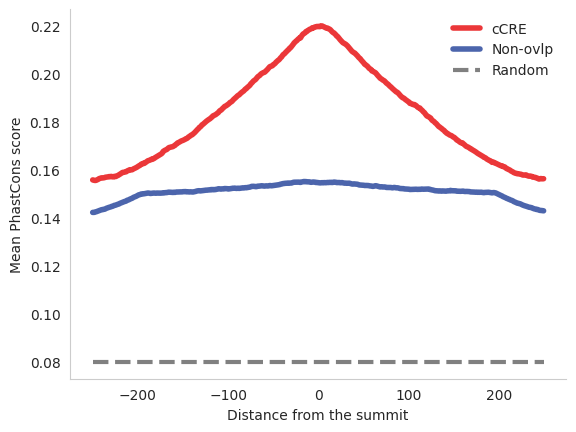

In [133]:
x = np.arange(-250, 250)
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

plt.plot(x, mean_value,color='#EB3739', label='cCRE',linewidth=4)
plt.plot(x, mean_value_non, color='#4C65AC', label='Non-ovlp',linewidth=4)
plt.plot(x, np.zeros_like(x)+0.08, color='grey',label='Random', linestyle='--', linewidth=3)
plt.xlabel('Distance from the summit')
plt.ylabel('Mean PhastCons score')
plt.legend(loc='upper right',frameon=False)
plt.grid(visible=False)
plt.axis('tight')
plt.gca().yaxis.set_major_formatter('{:.2f}'.format)

plt.show()

